In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt

In [6]:
df_path = os.path.join('..', 'data', 'train.csv')

In [7]:
df = pd.read_csv(df_path, dtype={'acoustic_data': np.int16, "time_to_failure": np.float64})
pd.options.display.precision = 15

In [ ]:
print(df)

# NO OF ELEMENTS IN THE TRAINING SET


In [8]:
print(df.shape[0])
print(df.describe())

629145480
               acoustic_data        time_to_failure
count  6.291454800000000e+08  6.291454800000000e+08
mean   4.519467573700124e+00  5.678291712978854e+00
std    1.073570724951096e+01  3.672696519443578e+00
min   -5.515000000000000e+03  9.550396316600001e-05
25%    2.000000000000000e+00  2.625996996050000e+00
50%    5.000000000000000e+00  5.349797741250000e+00
75%    7.000000000000000e+00  8.173395507775000e+00
max    5.444000000000000e+03  1.610740000000000e+01


# DATA DISTRIBUTION
- as it is clear from the previous cell there are very high peaks within the acoustic data, which represent
spikes in the distribution, since the lower and the uppertercile are significantly smaller, a box plot may also give a great vision of this

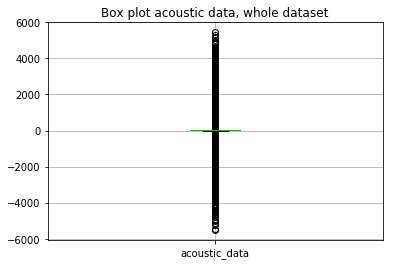

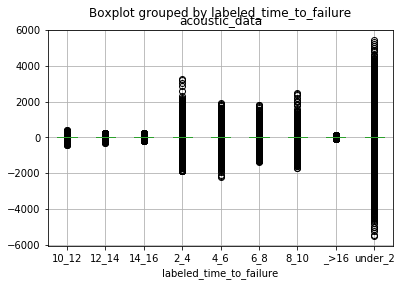

In [17]:
def time_labels(time_value):
    values_dict = ["under_2", "2_4", "4_6", "6_8", "8_10", "10_12", "12_14", "14_16", "_>16"]
    if time_value > 16:
        time_value = 16
    index = int(time_value/2)
    return values_dict[index]


# computing box_plot
df.boxplot(column=["acoustic_data"])
plt.title("Box plot acoustic data, whole dataset")
plt.show()
df2 = df.copy()
df2["labeled_time_to_failure"] = df2.time_to_failure.apply(time_labels)
df2.boxplot(column=["acoustic_data"], by="labeled_time_to_failure")
# plt.title("Box plot acoustic data vs labeled time to failure")
plt.show()


# BOX PLOT Comments

-From the first box plot it is visible how the max and min values are enormous peaks, whereas the greatest part of the distribution is located around the zero
-From the second box plot it is visible how the distribution tends to spread approaching the zero time-to-failure. What it is worth noticing is that it looks like the range between 8 and 10 seconds present higher peaks than 6_8, this is pretty visible in the plot of the acoustic_data signal, since there are several smaller peaks around the middle part of the signal preceding the higher ones near the zero. Maybe it should be important to define a threshold for those smaller peaks and detect them

# THRESHOLD BASED FEATURES

-From what we saw, acoustic signal tends to have very low values for the greatest part of the time, showing some high peaks when approaching to zero.
-Now, it would be interesting to 'code' this high peaks, coding also those middle-high peaks, by defining two different thresholds
-What should these thresholds be? I would start with a classic thumb rule th_mid_peaks = mean +- 2*std and th_high_peaks = mean+- 3*std
-Then I would analyse the percentage of values under these thresholds, hoping that it follows a normal distribution pattern
-If so, I would create a new column which would be 1 for all those acoustic peaks and zero otherwise
-When creating 150_000 rows segments, an additional feature will be the number of times mid peaks or high peaks are encountered

In [9]:
# mean and std of acoustic data

ac_data = df["acoustic_data"]
mean = ac_data.mean()
std = ac_data.std()
high_peaks = [mean -3*std, mean+3*std]
mid_peaks = [mean - 2*std, mean + 2*std]

df["high_peaks"] = df.acoustic_data.apply(lambda val: val>high_peaks[1] or val<high_peaks[0])
df["mid_peaks"] = df.acoustic_data.apply(lambda val: val>mid_peaks[1] or val<mid_peaks[0])

print(df.high_peaks.value_counts())
print(df.mid_peaks.value_counts())


False    625766370
True       3379110
Name: high_peaks, dtype: int64
False    621735652
True       7409828
Name: mid_peaks, dtype: int64


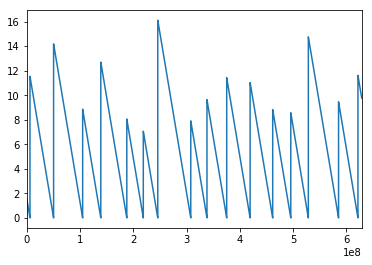

In [4]:
# PLOTTING TIME TO FAILURE SIGNAL

ttf = df.loc[:, "time_to_failure"]
ttf.plot()
plt.show()

### EARTHQUAKEOCCURRENCES
>It can be seen the presence of 16 different earthquakes in the training set

>The graph in the following cell is the printing of the training set time to failure


## FURTHER ANALYSIS

> It is interesting to notice how the signal has an important peak when approaching to the earthquake, it would be interesting to investigate the distribution of the acoustic signal values in order to define a threshold for counting the number of peaks above that threshold

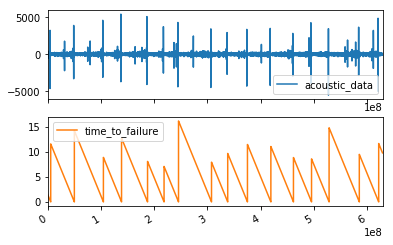

In [5]:
df.plot(subplots=True)
plt.show()

> It would be nice to compare statistical components of the signal nearby the fracture event with the other parts of the signal. The idea is that if some of those features are generally highly related to the approaching of the earthquake event, they could be useful for feature engineering purposes.

> The following cell compute statistical features of the whole training set, while the next one will compute the same statistical analysis applied nearby the fracture event


In [6]:
# computing the histogram

thresholds = [1, 5, 10, 20, 30, 50, 100]
percentages = []



df_acoustic = df[["acoustic_data"]]

# df.plot(kind='hist', bins=100)

acoustic_data_np = df.acoustic_data.values

no_acoustic_data_np = acoustic_data_np.shape[0]

for threshold in thresholds:

    acoustic_data_np_filtered = acoustic_data_np[np.logical_and(acoustic_data_np>-threshold, acoustic_data_np<threshold)]

    no_acoustic_data_np_filtered = acoustic_data_np_filtered.shape[0]
    
    percentages.append(no_acoustic_data_np_filtered/no_acoustic_data_np*100)

percentage_df = pd.DataFrame({'threshold':np.array(thresholds), 'percentage':np.array(percentages)})

print(percentage_df)

# percentage_df.set_index(percentage_df.threshold, inplace=True)


# percentage_df.plot()
# plt.show()


           percentage  threshold
0   4.219486405592551          1
1  47.243537853915754          5
2  90.065294278200966         10
3  98.476588435476003         20
4  99.331506601620973         30
5  99.774721738444342         50
6  99.952619066737952        100


In [ ]:
# I'd like to focus on the acoustic signal right before the earthquake event
# Let's filter out all the time to failure under 1.5 seconds

ttf_thresholds = np.linspace(0.1, 1.5, 1000)
print(ttf_thresholds.shape)
mean = []
std = []



for i in range(0, ttf_thresholds.shape[0]):
    df_under_1_5 = df.loc[df.time_to_failure < ttf_thresholds[i], :]
    mean.append(df_under_1_5.acoustic_data.mean())
    std.append(df_under_1_5.acoustic_data.std())
    
df_near_failure_stats = pd.DataFrame({'ttf_thresholds': ttf_thresholds, 'mean': np.array(mean), 'std': np.array(std)})

print(df_near_failure_stats)




# COMPUTING STATISTICAL FEATURES


In [10]:
ttf = df.time_to_failure.values

In [43]:
rows = 150000
no_segments = int(df.shape[0]/rows)
windows = [10, 100]

In [ ]:
# TEST CELL FOR FEATURES
'''
columns = ["max", "min", "mean", "std", "q_10", "q_20", "q_30", "q_40", "q_50", "q_60", "q_70", "q_80", "q_90",  "mpc", "hpc","ttf"]
features_df = pd.DataFrame(columns=columns)
for i in range(0, 2):
    seg_data_df = df.iloc[i*rows:i*rows +rows]
    seg_data = seg_data_df["acoustic_data"]
    max_val = seg_data.max()
    min_val = seg_data.min()
    mean = seg_data.mean()
    q_10 = seg_data.quantile(q=0.1)
    q_20 = seg_data.quantile(q=0.2)
    q_30 = seg_data.quantile(q=0.3)
    q_40 = seg_data.quantile(q=0.4)
    q_50 = seg_data.quantile(q=0.5)
    q_60 = seg_data.quantile(q=0.6)
    q_70 = seg_data.quantile(q=0.7)
    q_80 = seg_data.quantile(q=0.8)
    q_90 = seg_data.quantile(q=0.9)
    std = seg_data.std()  
    mpc = seg_data_df[seg_data_df.mid_peaks == 1]["mid_peaks"].sum()
    hpc = seg_data_df[seg_data_df.high_peaks == 1]["high_peaks"].sum()
    ttf = seg_data_df["time_to_failure"].iloc[seg_data_df.shape[0]-1] 
    values = [max_val, min_val, mean, std, q_10, q_20, q_30, q_40, q_50, q_60, q_70, q_80, q_90, mpc, hpc, ttf]
    features_df.loc[i, columns] = values
    for window in windows:  
        features_df.loc[i, "roll_ma_avg_" + str(window)] = seg_data.rolling(window=window).mean().mean()
        features_df.loc[i, "roll_ma_std_" + str(window)] = seg_data.rolling(window=window).mean().std()
        features_df.loc[i, "roll_kurt_avg_" + str(window)] = seg_data.rolling(window=window).kurt().dropna().mean()
        features_df.loc[i, "roll_kurt_std_" + str(window)] = seg_data.rolling(window=window).kurt().dropna().std()
'''

In [12]:
columns = ["max", "min", "mean", "std", "q_10", "q_20", "q_30", "q_40", "q_50", "q_60", "q_70", "q_80", "q_90",  "mpc", "hpc","ttf"]
features_df = pd.DataFrame(columns=["max", "min", "mean", "std", "q_10", "q_20", "q_30", "q_40", "q_50", "q_60", "q_70", "q_80", "q_90",  "mpc", "hpc","ttf"])
for i in range(0, no_segments):
    seg_data_df = df.iloc[i*rows:i*rows +rows]
    seg_data = seg_data_df["acoustic_data"]
    max_val = seg_data.max()
    min_val = seg_data.min()
    mean = seg_data.mean()
    q_10 = seg_data.quantile(q=0.1)
    q_20 = seg_data.quantile(q=0.2)
    q_30 = seg_data.quantile(q=0.3)
    q_40 = seg_data.quantile(q=0.4)
    q_50 = seg_data.quantile(q=0.5)
    q_60 = seg_data.quantile(q=0.6)
    q_70 = seg_data.quantile(q=0.7)
    q_80 = seg_data.quantile(q=0.8)
    q_90 = seg_data.quantile(q=0.9)
    std = seg_data.std()  
    mpc = seg_data_df[seg_data_df.mid_peaks == 1]["mid_peaks"].sum()
    hpc = seg_data_df[seg_data_df.high_peaks == 1]["high_peaks"].sum()
    ttf = seg_data_df["time_to_failure"].iloc[seg_data_df.shape[0]-1] 
    values = [max_val, min_val, mean, std, q_10, q_20, q_30, q_40, q_50, q_60, q_70, q_80, q_90, mpc, hpc, ttf]
    features_df.loc[i] = values
    for window in windows:  
        features_df.loc[i, "roll_ma_avg_" + str(window)] = seg_data.rolling(window=window).mean().mean()
        features_df.loc[i, "roll_ma_std_" + str(window)] = seg_data.rolling(window=window).mean().std()
        features_df.loc[i, "roll_std_avg_" + str(window)] = seg_data.rolling(window=window).std().mean()
        features_df.loc[i, "roll_ma_std_" + str(window)] = seg_data.rolling(window=window).mean().std()
        features_df.loc[i, "roll_kurt_avg_" + str(window)] = seg_data.rolling(window=window).kurt().dropna().mean()
        features_df.loc[i, "roll_kurt_std_" + str(window)] = seg_data.rolling(window=window).kurt().dropna().std()
        features_df.loc[i, "roll_avg_q10_" + str(window)] = seg_data.rolling(window=window).mean().quantile(q=0.1)
        features_df.loc[i, "roll_avg_q90_" + str(window)] = seg_data.rolling(window=window).mean().quantile(q=0.9)    
        features_df.loc[i, "roll_avg_q01_" + str(window)] = seg_data.rolling(window=window).mean().quantile(q=0.01)    
        features_df.loc[i, "roll_avg_q05_" + str(window)] = seg_data.rolling(window=window).mean().quantile(q=0.05) 
        features_df.loc[i, "roll_avg_q95_" + str(window)] = seg_data.rolling(window=window).mean().quantile(q=0.95)    
        features_df.loc[i, "roll_avg_q99_" + str(window)] = seg_data.rolling(window=window).mean().quantile(q=0.99)    


  

In [16]:
no_features = features_df.shape[0]
print(features_df.head)

<bound method NDFrame.head of          max     min               mean            ma_mean  \
0      104.0   -98.0  4.884113333333334  4.883789808988039   
1      181.0  -154.0  4.725766666666667  4.725525310697515   
2      140.0  -106.0  4.906393333333333  4.906059352289940   
3      197.0  -199.0  4.902240000000000  4.901917682675902   
4      145.0  -126.0  4.908720000000000  4.909240868151253   
5      142.0  -144.0  4.913513333333333  4.913513556799753   
6      120.0   -78.0  4.855660000000000  4.855751068283384   
7      139.0  -134.0  4.505426666666667  4.505016983536980   
8      168.0  -156.0  4.717833333333333  4.718154433403847   
9      152.0  -126.0  4.730960000000000  4.731084744179218   
10     245.0  -115.0  4.582873333333334  4.582649921143891   
11     410.0  -478.0  4.329933333333333  4.330030096562585   
12     224.0  -169.0  4.464040000000000  4.464520712796934   
13     139.0  -129.0  4.680813333333333  4.680703498808815   
14      98.0  -125.0  4.596720000000000 

# COMMENTS ON OBTAINED DATAFRAME
- The final obtained dataframe is made of 4194 rows
- Each row is related to a segment made of 150_000 rows, plus its corresponding features
- The last column represents the time to failure for that specific row
- The analysis below doesn't show important correlations with the output variable, but it gives an hint about some elements.
- For example, max and min peaks are only visible approaching the earthquake, and tipically happens very close to zero
- Also the standard deviatiom, tends to be very high approaching the zero and tends to increase for each interval closer to the earhquake
- This also reflects to the quartiles, q10 has very low values approaching the earthquake, while tends to be around -2.5 and 2.5 when the earthquake is still temporarly far, this behavior is less visible for q_20 and it's not visible for q_30, q_40, q_50 and q_60. It tends to be back starting from q_70, and it starts to become clear for q_80 and q_90 with an inverse correlation 
- mpc are significantly present approaching the earthquake as well as hpc


Working on 0
Working on 1
Working on 2
Working on 3
Working on 4
Working on 5
Working on 6
Working on 7
Working on 8
Working on 9
Working on 10
Working on 11
Working on 12
Working on 13
Working on 14
Working on 15


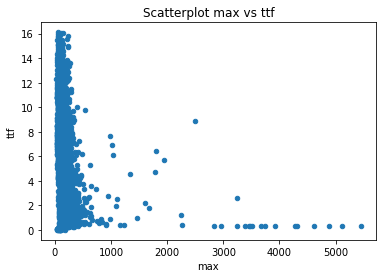

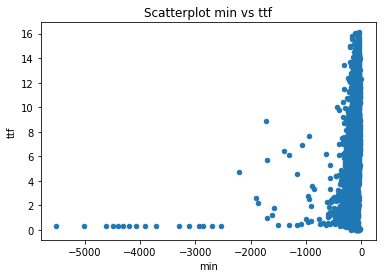

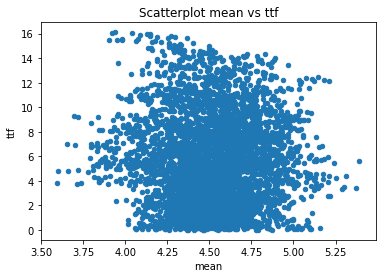

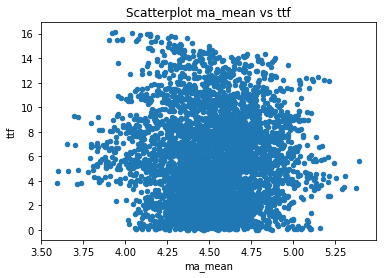

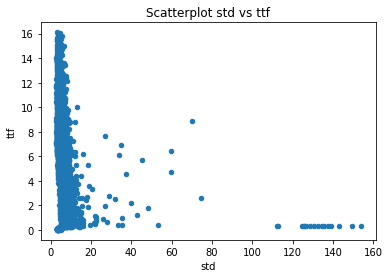

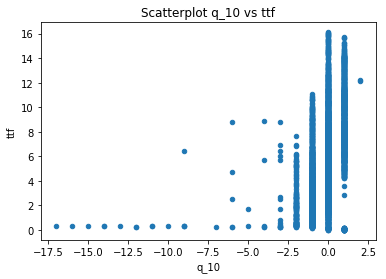

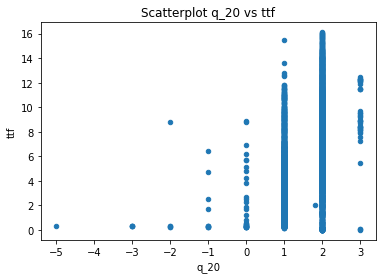

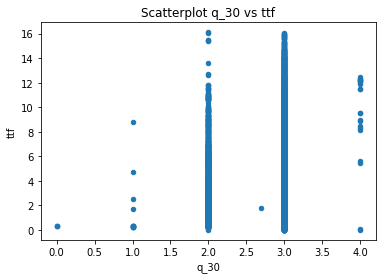

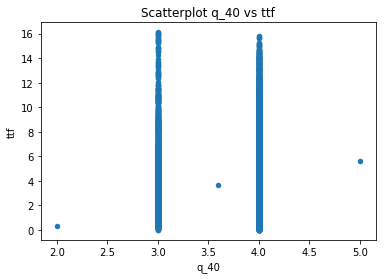

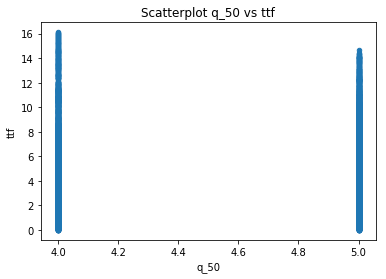

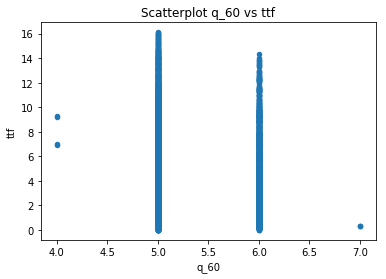

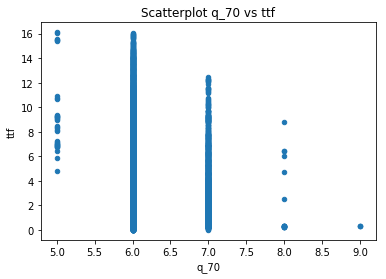

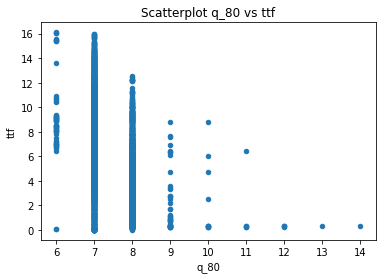

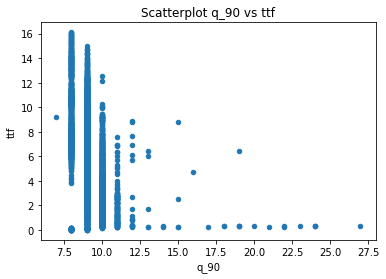

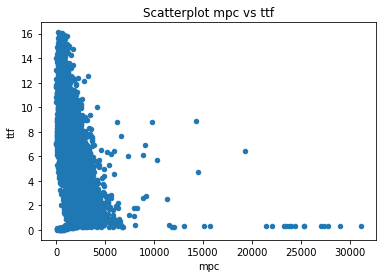

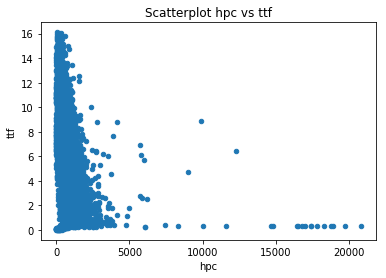

In [26]:
columns = ["max", "min", "mean", "ma_mean", "std", "q_10", "q_20", "q_30", "q_40", "q_50", "q_60", "q_70", "q_80", "q_90",  "mpc", "hpc", "ttf"]

for i in range(0, len(columns)-1):
    
    print("Working on {0}".format(i))
    features_df.plot(kind="scatter", x = columns[i], y = columns[-1])
    plt.title("Scatterplot {0} vs {1}".format(columns[i], columns[-1]))


# CONCLUSIONS
- In my opinion, some of the inner quartile features may be eliminated, since they don't bring any additional value to the analysis
- It would be interesting to further investigate mpc and hpc features and std as well
- Mean and MaMean don't bring apparently any interesting additional value to the model, I'd like to further investigate this behaviour with a simple plot showing the mean and mamean behavior over the time to failure behaviour and so on

# PLOTTING FEATURES 

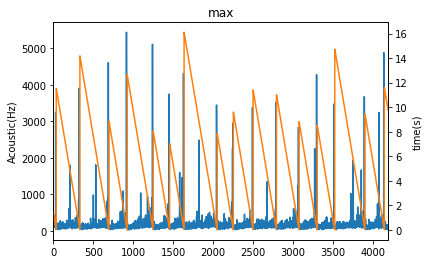

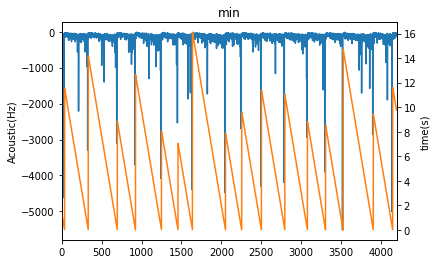

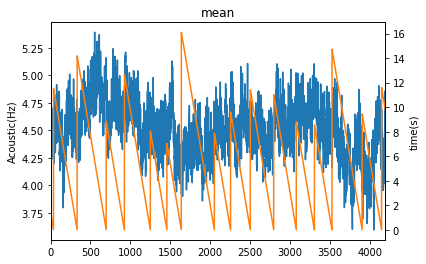

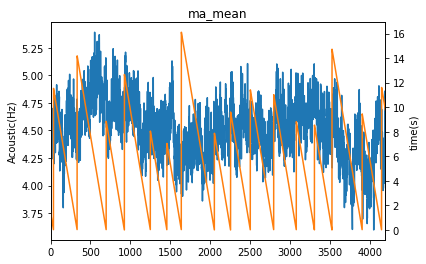

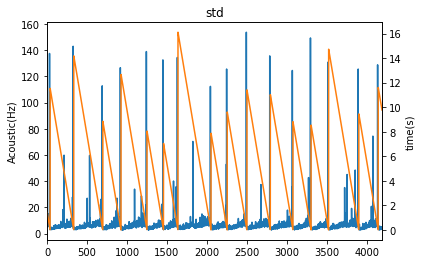

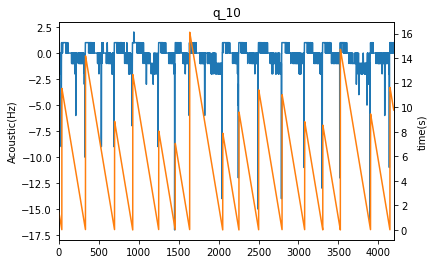

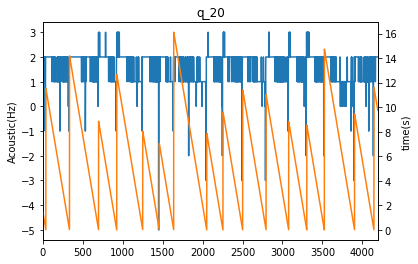

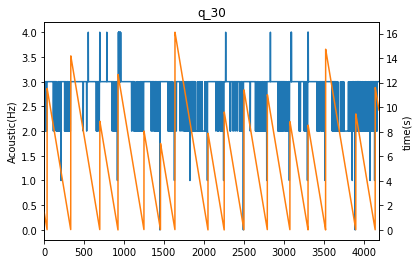

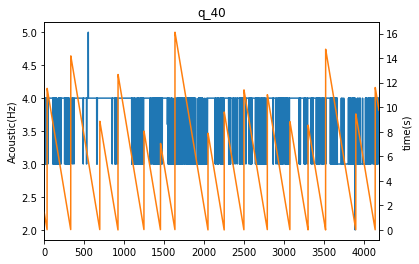

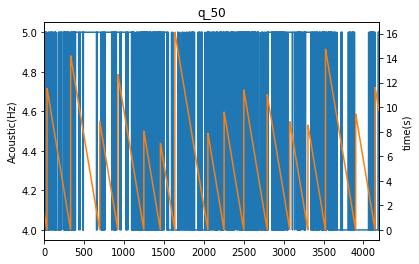

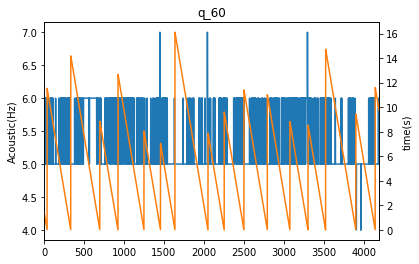

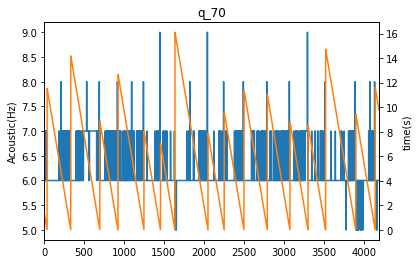

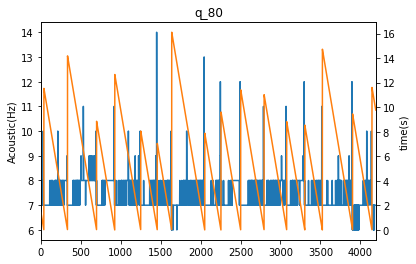

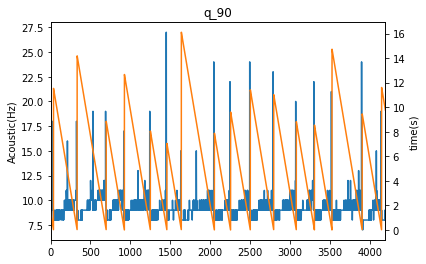

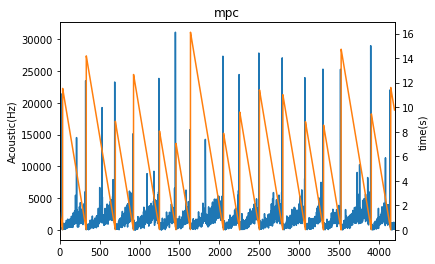

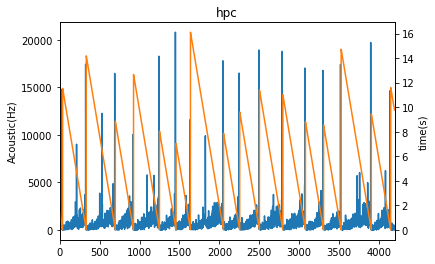

In [33]:
for i in range(0, len(columns) - 1):
    features_ax = features_df[columns[i]].plot()
    features_ax.set_ylabel("Acoustic(Hz)")
    ttf_ax = features_df["ttf"].plot(secondary_y=True)
    ttf_ax.set_ylabel("time(s)")
    plt.title("{0}".format(columns[i]))
    plt.show()

In [ ]:
# Let's take only the features that graphically seem to give good results

columns = ["max", "min", "std", "q_10", "q_80", "q_90", "mpc", "hpc"]

training_df = features_df.loc[:, columns]

print(training_df.head)

In [ ]:
# features distribution to apply some normalization technique

